In [1]:
from datascience import *
import numpy as np
import pandas as pd
from math import *
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Lesson 35: Regression

Over the last two lessons, you went over regression in Data 8.3x. In these sections, you learned how to calculate the slope and intercept of a line fit to a bivariate sample. For example, using the `baby.csv` dataset, you can use regression to predict birthweight given the gestational age of the baby at birth. 

### Exercise 1

Find the least squares line that predicts birthweight based on the gestational age of a baby. You should use `minimize`, an optimization method in the `datascience` package. Note that you could use standardization (similar to what they did in Data 8.3x, `lec7.ipynb`) but the resulting intercept and slope would be in standardized units, and would need to be transformed in order to be interpretable. 

An example of minimize can be found in the [text book](https://www.inferentialthinking.com/chapters/15/3/Method_of_Least_Squares#minimizing-the-root-mean-squared-error)

In [2]:
baby = Table.read_table('baby.csv')
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


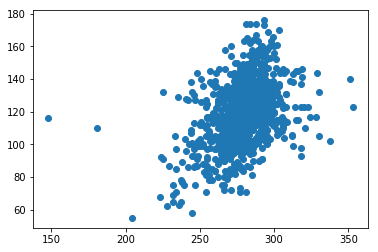

In [3]:
plt.scatter(baby.column(1),baby.column(0))
plt.show()

In [4]:
def baby_mse(any_slope, any_intercept):
    x = baby.column(1)
    y = baby.column(0)
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)

In [5]:
minimize(baby_mse)

array([ 0.4284037 , -0.07039869])

In the context of the data, interpret the intercept and slope. 

For one extra day of gestation, the average birth weight of a baby increases by 0.43 grams.

The slope is 0.428. It seems reasonable to expect this slope to be significantly higher than zero; it makes sense that gestational age would impact birthweight. Let's check using bootstrapping. 

In [6]:
def errors(t, slope, intercept):
    errors = t.column(0) - (t.column(1)*slope + intercept)
    return errors

In [7]:
def fit_line(tbl):
    # Your code may need more than 1 line below here.
    # Rather than using the regression line formulas, try
    # calling minimize on the mean squared error.
    # We need a function for errors
    def mse(slope,intercept):
        return np.mean(errors(tbl, slope, intercept)**2)
    answer = minimize(mse)
    slope = answer.item(0)
    intercept = answer.item(1)
    return make_array(slope, intercept)

In [8]:
fit_line(baby)

array([ 0.4284037 , -0.07039869])

In [9]:
bootstrap_slope = make_array()

for i in np.arange(1000):
    bootstrap_slope = np.append(bootstrap_slope,(fit_line(baby.sample()).item(0)))

results = Table().with_column("Slope estimate", bootstrap_slope)
results

Slope estimate
0.426719
0.429943
0.426769
0.432283
0.428911
0.429063
0.4287
0.428634
0.428726
0.429007


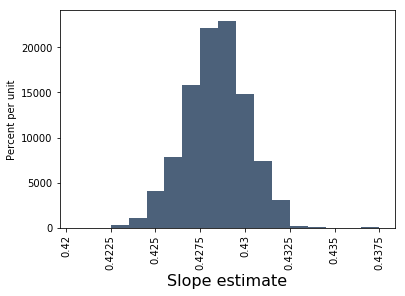

In [10]:
results.hist(bins=np.arange(.4205, .4375, .001))

In [11]:
lower_end = np.percentile(bootstrap_slope,2.5)
upper_end = np.percentile(bootstrap_slope,97.5)
print("95% confidence interval for the slope of the regression: [{:g}, {:g}]".format(lower_end, upper_end))

95% confidence interval for the slope of the regression: [0.424763, 0.431971]


In [12]:
np.mean(bootstrap_slope)

0.4295542022386204

### Exercise 2

For a baby born at 40 weeks gestational age, what do we expect to be the average birthweight according to this model?

In [13]:
coef=fit_line(baby)
coef

array([ 0.4284037 , -0.07039869])

In [14]:
def predict(coef,value):
    return (value*coef[0] + coef[1])

In [15]:
predict(coef,280)

119.88263715253427

Using bootstrapping, build a 95% confidence interval around this estimate. Interpret this interval, carefully. 

I did not save the intercepts from my bootstrap so I will have to use point slope.

In [16]:
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [17]:
bootstrap_ave_weight = make_array()

for i in np.arange(1000):
    bootstrap_ave_weight = np.append(bootstrap_ave_weight,predict(fit_line(baby.sample()),280))

In [18]:
lower_end = np.percentile(bootstrap_ave_weight,2.5)
upper_end = np.percentile(bootstrap_ave_weight,97.5)
print("95% confidence interval for the average weight at 40 weeks: [{:g}, {:g}]".format(lower_end, upper_end))

95% confidence interval for the average weight at 40 weeks: [118.917, 120.849]


In [19]:
results = Table().with_column("Ave Weight", bootstrap_ave_weight)
results

Ave Weight
120.046
119.596
119.831
120.824
119.355
119.919
119.774
119.97
118.635
120.296


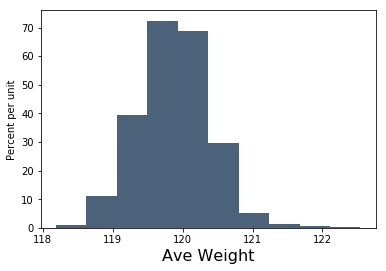

In [20]:
results.hist()

This is a confidence inteval on the **mean** birthweight for a baby born at 40 weeks. 

### Exercise 3

Suppose a baby is born at 40 weeks. Let's construct a confidence interval for the birthweight of *that baby*. This is different than the confidence interval on the mean birthweight of babies born at 40 weeks. This interval is known as a prediction interval. 

A simple way to find the prediction interval is to sample many times (with replacement) from the observed residuals and add to the predicted birthweight under the linear model. Find the percentiles of these simulations to obtain the interval. 

In [21]:
coef=fit_line(baby)
coef

array([ 0.4284037 , -0.07039869])

In [22]:
resid=errors(baby,coef[0],coef[1])

In [23]:
np.random.choice(resid,size=1)

array([10.11853695])

In [24]:
bootstrap_pred_weight = make_array()

for i in np.arange(1000):
    bootstrap_pred_weight = np.append(bootstrap_pred_weight,np.sqrt((predict(fit_line(baby.sample()),280))**2+
                                      (np.random.choice(resid,size=1))**2))

In [26]:
bootstrap_pred_weight = make_array()

for i in np.arange(1000):
    bootstrap_pred_weight = np.append(bootstrap_pred_weight,predict(fit_line(baby.sample()),150)+
                                      np.random.choice(resid,size=1))

In [27]:
lower_end = np.percentile(bootstrap_pred_weight,2.5)
upper_end = np.percentile(bootstrap_pred_weight,97.5)
print("95% confidence interval for the predicted weight at 40 weeks: [{:g}, {:g}]".format(lower_end, upper_end))

95% confidence interval for the predicted weight at 40 weeks: [29.7642, 96.751]


It turns out that this method is a little oversimplified. A "more correct" method is below. This requires taking into account the *leverage* of each data point (basically a measure of impact to the model of each data point). 

In [57]:
slope = coef[0]
intercept = coef[1]
pred=intercept+slope*150
leverage=1/baby.num_rows + ((baby.column(1)-np.mean(baby.column(1)))**2)/np.sum(((baby.column(1)-np.mean(baby.column(1)))**2))
adjresiduals=resid/np.sqrt(1-leverage)

bs_all=[]
for _ in np.arange(5000):
    bs_y=(intercept+slope*baby.column(1))+np.random.choice(adjresiduals,size=baby.num_rows,replace=True)
    resample=Table().with_columns("y",bs_y,"x",baby.column(1))
    bs_slope,bs_intercept=minimize(mse_resample)
    bs_residuals=bs_y-(bs_intercept+bs_slope*baby.column(1))
    bs_adjresiduals=bs_residuals/np.sqrt(1-leverage)
    bs_all=np.append(bs_all,150*(slope-bs_slope)+np.random.choice(bs_adjresiduals))

percentile([2.5,97.5],pred+bs_all)

NameError: name 'mse_resample' is not defined